# Convertidor semi puente boost compacto (CSPBC)

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xmlrpc.client as xml
from scipy.optimize import fsolve, minimize

Se espera obtener un conversor que tenga:

- $V_o=400 \ V_{DC}$
- $V_i=48 \ V_{DC}$
- $0 < I_o < 40 \ A$
- Se pueden conectar en paralelo.

### Características deseadas en el convertidor

Se decide por construir un conversor de $4.5 \ kW$, de forma de aproximar la salida a la máxima corriente solicitada como variación, y se define a la tensión de entrada como $V_{in(max)}=288V$, que equivale a 6 paneles en serie. La frecuencia de conmutación será de $f_s=50 \ kHz$, $T_s=20 \ \mu s$. Se tiene entonces que las tensiones y corrientes del convertidor se definen como la tensión de salida nominal referida al primario del transformador y la corriente máxima de salida nominal referida al primario. Así, se tiene:

- $V_{oB}'=n400V$
- $I_{oB}'=\frac{P_n}{nV_o}=\frac{11.25}{n}A$

### Definición de la relación de vueltas del transformador y el rango de tensión de entrada

Para trabajar en conmutación suave, es conveniente trabajar con un rango de tensión de entrada de:
$$0.42 < V_{inpu} <0.9$$

Por lo que se limita en $V_{inpu} <0.9$. Ahora, si reemplazo esa igualdad en el valor de tensión base, se obtiene:

$$n > \frac{V_{in(max)}}{0.9V_{oB}} = 0.8$$

Con ese valor de conversión, resulta $V_{oB}'=320V$ y $I_{oB}'=14.06A$. Por la condición de arranque suave, y la máxima tensión definida anteriormente, se tiene que $134.4V < V_{in} < 288 V$.

### Definición de los valores de inductancia de dispersión y magnetización del transformador

La impedancia base del convertidor a implementar está dada por:

$$ R_B=\frac{V_{oB}'}{I_{oB}'} = \frac{320V}{14.06A} = 22.76 \Omega$$

Como el período de la señal de conmutación es $T_{sB}=20 \mu s$ y la inductancia $L_B=\frac{R_B T_B}{2\pi}=72.45 \mu H$. Este último valor se usa para la inductancia de magnetización, y para la de dispersión se usa un 10% de la recientemente calculada.

### Definición de los valores de los capacitores del semipuente

Se definen:

- $C_L=100\mu F$
- $C_U=22 \mu F$
- $C_{RL}=8 \mu F$

### Resumen de parámetros

| Parámetro | Valor       |
|-----------|-------------|
| $P_{N}$     | $4.5 kW $     |
| $V_{oN}$    | $400 V$       |
| $V_{in}$      | $134.4 - 288V$|
| $f_s$       | $50 kHz$      |
| $C_L$       | $100 \mu F$      |
| $C_U$       | $22 \mu F$       |
| $C_{RL}$      | $8 \mu F$        |
| $L_{mp}$      | $72.45 \mu H$    |
| $L_{LKp}$     | $7.25 \mu H$     |
| $n$         | $0.8$         |

In [80]:
Vinmax = 51
Vinmin = 30
Vin = 48
fs = 50000
Ts = 1/fs
Vout = 400
Iout = 10
Lk = 100e-6

In [67]:
Dmax = Vinmax/(Vinmin+Vinmax)
Dmin = 1-Dmax

In [77]:
Dmax

0.6296296296296297

In [78]:
D = 0.5

In [68]:
Tres1max = (1-Dmax)*Ts
Tres2max = Dmin*Ts

In [82]:
Tres1max, Tres2max

(7.4074074074074075e-06, 7.4074074074074075e-06)

In [83]:
Tres1 = Tres2 = 7e-6

Para un $D=0.5$:

In [131]:
Vbus = Vinmax+Vinmin
Vbus

81

In [70]:
n = Vout/Vbus

In [121]:
n

4.938271604938271

In [72]:
IL = (1/n)*Iout*1.1

In [73]:
riple = 0.05

In [74]:
Lin = Vbus*Ts/(4*IL*riple)

In [130]:
Lin

0.0036363636363636355

In [79]:
ILrms = np.sqrt(IL**2+D**2*Vinmax*Ts/(12*Lin**2))

In [109]:
initial_it = [1e-7, 1e-7]
Tres1_values = np.linspace(1e-6, Tres1max, 100)
Tres2_values = np.linspace(1e-6, Tres2max, 100)
data = []

In [110]:
def Tres(vars, Tres1, Tres2):
    CL, CH = vars
    eq1 = Tres1 - np.pi * np.sqrt((Lk * 2 * CL * n**2 * CH) / (CL + n**2 * CH))
    eq2 = Tres2 - np.pi * np.sqrt((2 * Lk * n**2 * CL * CH) / (CL + 2 * n**2 * CH))
    return [eq1, eq2]


In [111]:
def calculate_CL_CH_with_constraints(Tres1, Tres2):
    def objective(vars):
        return 0  # No importa el valor, solo nos interesa cumplir las restricciones

    constraints = [
        {'type': 'eq', 'fun': lambda vars: Tres(vars, Tres1, Tres2)[0]},
        {'type': 'eq', 'fun': lambda vars: Tres(vars, Tres1, Tres2)[1]},
        {'type': 'ineq', 'fun': lambda vars: vars[0]},  # CL >= 0
        {'type': 'ineq', 'fun': lambda vars: 100e-6 - vars[0]},  # CL <= 100e-6
        {'type': 'ineq', 'fun': lambda vars: vars[1]},  # CH >= 0
        {'type': 'ineq', 'fun': lambda vars: 100e-6 - vars[1]}   # CH <= 100e-6
    ]

    result = minimize(objective, initial_it, constraints=constraints)
    return result.x if result.success else (None, None)

In [112]:
for Tres1_val, Tres2_val in zip(Tres1_values, Tres2_values):
    CL, CH = calculate_CL_CH_with_constraints(Tres1_val, Tres2_val)
    data.append((Tres1_val, Tres2_val, CL, CH))

C:\Users\fedef\AppData\Local\Temp\ipykernel_23964\1326923775.py:3: RuntimeWarning: invalid value encountered in sqrt
  eq1 = Tres1 - np.pi * np.sqrt((Lk * 2 * CL * n**2 * CH) / (CL + n**2 * CH))
C:\Users\fedef\AppData\Local\Temp\ipykernel_23964\1326923775.py:4: RuntimeWarning: invalid value encountered in sqrt
  eq2 = Tres2 - np.pi * np.sqrt((2 * Lk * n**2 * CL * CH) / (CL + 2 * n**2 * CH))


In [113]:
df = pd.DataFrame(data, columns=['Tres1', 'Tres2', 'CL', 'CH'])

In [114]:
df

,Tres1,Tres2,CL,CH
0,0.000001,0.000001,2.240076e-08,3.956355e-11
1,0.000001,0.000001,2.366097e-08,4.490126e-11
2,0.000001,0.000001,2.494978e-08,5.010062e-11
3,0.000001,0.000001,2.628070e-08,5.496663e-11
4,0.000001,0.000001,2.767422e-08,5.927506e-11
...,...,...,...,...
95,0.000007,0.000007,NaN,NaN
96,0.000007,0.000007,2.896445e-07,1.070953e-09
97,0.000007,0.000007,1.092799e-07,1.654026e-09
98,0.000007,0.000007,1.096257e-07,1.824067e-09


Se decide utilizar $C_L=316nF$ y $C_H=1.46nF$.

In [125]:
CL = 316e-6
CH = 1.46e-9
Tres1 = Tres2 = 7e-6

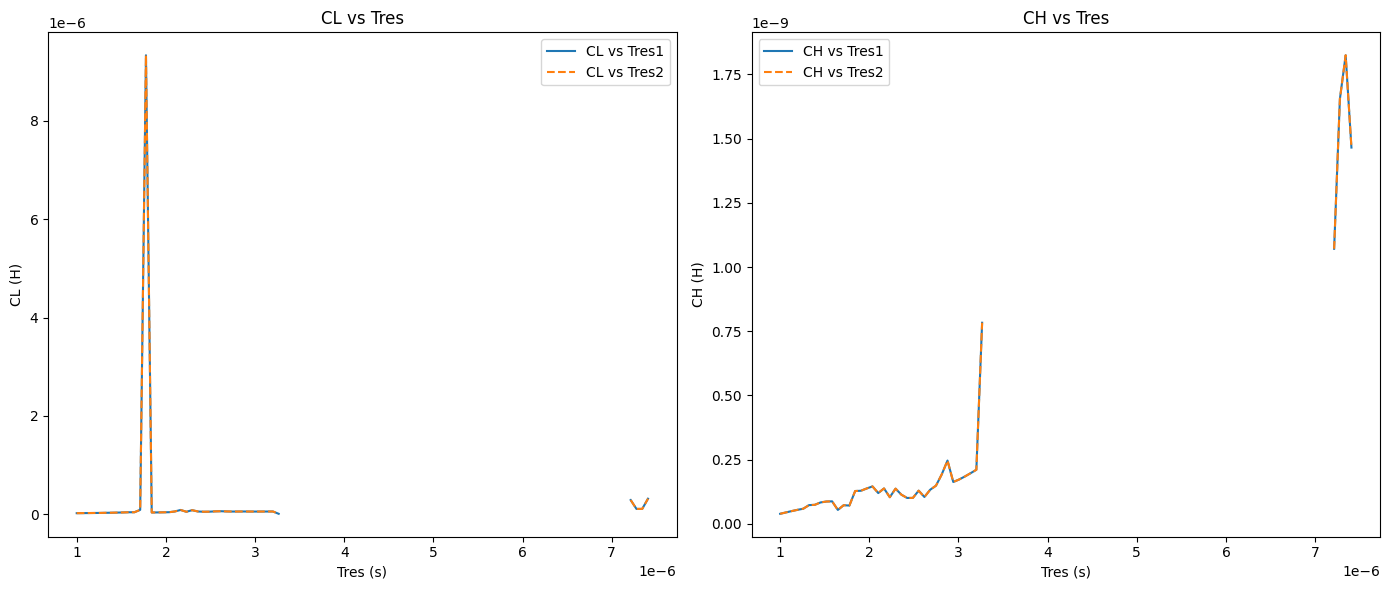

In [124]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df['Tres1'], df['CL'], label='CL vs Tres1')
plt.plot(df['Tres2'], df['CL'], label='CL vs Tres2', linestyle='--')
plt.xlabel('Tres (s)')
plt.ylabel('CL (H)')
plt.title('CL vs Tres')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df['Tres1'], df['CH'], label='CH vs Tres1')
plt.plot(df['Tres2'], df['CH'], label='CH vs Tres2', linestyle='--')
plt.xlabel('Tres (s)')
plt.ylabel('CH (H)')
plt.title('CH vs Tres')
plt.legend()

plt.tight_layout()

In [126]:
RL = Vout/Iout

In [127]:
Vriple = 0.05*Vout

In [128]:
C5 = Vout/RL*(Ts/(2*Tres2)-1)*Tres2/Vriple

In [129]:
C5

1.5000000000000002e-06

## Simulación

In [33]:
model = 'simulation'
fyle_type = '.plecs'
plecs = xml.Server('http://localhost:1080/RPC2').plecs